In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms 
from tqdm.notebook import trange, tqdm
from pathlib import Path
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
imgs_path = Path('set-lipstick-original').joinpath('720p')
target_path = Path('set-lipstick-original').joinpath('mask')

In [304]:
df = pd.read_csv('list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [4]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [358]:
class Lips(Dataset):
    def __init__(self, data, transform = None):
        """
        :param transform: transforms of the images and labels
        """
        self.transform = transform
        self.data = data[['filename', 'mask']]
        self.imgs_path = Path('set-lipstick-original').joinpath('720p')
        self.targets_path = Path('set-lipstick-original').joinpath('mask')
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index: int):
        try:
            img = Image.open(self.imgs_path.joinpath(self.data.loc[index, 'filename']))
            target = Image.open(self.targets_path.joinpath(self.data.loc[index, 'mask'])).convert('L')

            if self.transform:
                img = self.transform(img)
                target = self.transform(target)
                target = (target > 0).float()

            return img, target
        except FileNotFoundError:
            return self.__getitem__(0)

    def __len__(self):
        return self.data.shape[0]

In [359]:
dataset = Lips(df,
               transform=transforms.Compose([
                   transforms.Resize((256, 256)),
                   transforms.ToTensor()
               ]))

In [372]:
unet = Unet(classes=1, activation='sigmoid')

In [367]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

In [377]:
for epoch in range(2):
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    batch = 0
    for imgs, targets in train_loader:
        optimizer.zero_grad()
        preds = unet(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        print(f'batch {batch+1} finished')
        batch += 1
    print(f'epoch {epoch+1} finished')

### Обучился на 10 батчах, на таком кол-ве данных, конечно,  получается что-то странное

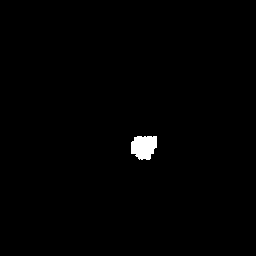

In [374]:
to_pil(dataset[0][1])

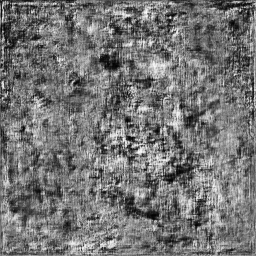

In [376]:
to_pil(unet(dataset[0][0].unsqueeze(0))[0])